In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import random
import seaborn as sns
import pandas_datareader as web
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import plotly.express as px
from datetime import datetime
Time=datetime.now()
Start=datetime.today().strftime("%H:%M:%S")
Start=datetime.strptime(Start,"%H:%M:%S")

In [60]:
start_date = datetime(2022, 9, 22,)
day=12
end_date=datetime(Time.year,Time.month,day,18)
df = yf.download('NFLX',start_date,end_date)
df_target=yf.download('NFLX',start_date,Time)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [63]:
df_target.columns=df_target.columns.str.lower()

In [4]:
df.columns=df.columns.str.lower()
df=df.round(2)


In [5]:
df["Target"]=df["close"].shift(-1).ffill()
np.random.seed(42)
df["open_shift"]=np.random.uniform(200,443,size=df.shape[0])
df["high_shift"]=np.random.uniform(300,485,size=df.shape[0])
df["low_shift"]=np.random.uniform(250,470,size=df.shape[0])
df["volume_shift"]=np.random.uniform(3.298,22128.300,size=df.shape[0])
filt1=df.columns.isin(["open","Target","high","low","close","low_shift","volume","adj close"])
Predictors1=df.columns[~filt1]


In [6]:
df

,open,high,low,close,adj close,volume,Target,open_shift,high_shift,low_shift,volume_shift
Date,,,,,,,,,,,
2022-09-22,235.35,240.50,231.66,237.05,237.05,10018000,226.41,291.013249,428.947912,469.260104,15416.698872
2022-09-23,235.14,236.45,221.43,226.41,226.41,11207200,224.07,431.023576,429.959556,372.194975,20413.598654
2022-09-26,225.60,232.70,223.01,224.07,224.07,8234300,224.36,377.874528,366.505863,419.177231,15650.954199
2022-09-27,228.63,230.64,220.72,224.36,224.36,7762200,245.20,345.474012,354.314491,457.848461,3378.224630
2022-09-28,229.69,246.65,227.38,245.20,245.20,17579700,239.71,237.912530,449.731814,436.922426,12753.679121
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-06,368.43,382.52,367.77,381.51,381.51,4773400,385.95,440.583086,350.580308,384.519932,13886.857629
2023-10-09,378.05,387.17,377.76,385.95,385.95,3299800,373.32,234.040416,310.429467,253.984240,19333.405899
2023-10-10,385.58,388.70,372.25,373.32,373.32,7288900,365.93,325.954106,459.973640,441.867260,21776.146724


In [7]:
null_pct=df.apply(pd.isna).sum()/df.shape[0]

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
filt=df.columns.isin(["Target","adj close","high","close","low","open_shift","low_shift","high_shift","volume_shift"])
predictors=df.columns[~filt]
lg=LogisticRegression()
R=LinearRegression()
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
r=Ridge(alpha=1.0)
scaler=StandardScaler()
S=Sequential()
X=df[predictors]
y=df["Target"]
ros=RandomOverSampler()

In [10]:
def backtest(data,model,predictors,oversample=False,start=100,step=90):
    all_predictors=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[:i]
        test=data.iloc[i:i+step]
        X_train=train[predictors]
        y_train=train["Target"]
        X_test=test[predictors]
        y_test=test["Target"]
        model.fit(X_train,y_train)
        preds=model.predict(X_test)
        preds=pd.Series(preds,index=test.index)
        Combined=pd.DataFrame(dict(Actual=y_test,Predicted=preds))
        Combined["Diff"]=(Combined["Actual"]-Combined["Predicted"]).abs()
        all_predictors.append(Combined)       
    return pd.concat(all_predictors)
    
def forecast_next_days(data, model,predictors,oversample=False,step=5, num_days=5):
    last_train = data.iloc[-step:]
    #last_train_f = last_train.filter(["Target"])
    #last_train1 = scaler.fit_transform(last_train_f)
    next_days = pd.date_range(
        start=last_train.index[-1] + pd.Timedelta(days=1),
        periods=num_days
    )
    X_train=last_train[predictors]
    y_train=last_train["Target"]
    G = np.random.uniform(370, 390, size=num_days)
    sample_rows = pd.Series(G)
    model.fit(X_train,y_train)
    next_preds = model.predict(last_train[predictors][:num_days])
    next_preds=pd.Series(next_preds,index=next_days)
    #next_preds = model.predict(last_train_f[:num_days])
    #next_preds = scaler.inverse_transform(next_preds)
    next_diff = np.abs(sample_rows.values - next_preds.values)

    next_preds_df = pd.DataFrame({
        "Actual": sample_rows.values,
        "Predicted": next_preds.values,
        "Diff": next_diff
    }, index=next_days)

    return next_preds_df


In [11]:
Combined= backtest(df,R, predictors)

Combined5=forecast_next_days(df,R,Predictors1)


In [12]:
df

,open,high,low,close,adj close,volume,Target,open_shift,high_shift,low_shift,volume_shift
Date,,,,,,,,,,,
2022-09-22,235.35,240.50,231.66,237.05,237.05,10018000,226.41,291.013249,428.947912,469.260104,15416.698872
2022-09-23,235.14,236.45,221.43,226.41,226.41,11207200,224.07,431.023576,429.959556,372.194975,20413.598654
2022-09-26,225.60,232.70,223.01,224.07,224.07,8234300,224.36,377.874528,366.505863,419.177231,15650.954199
2022-09-27,228.63,230.64,220.72,224.36,224.36,7762200,245.20,345.474012,354.314491,457.848461,3378.224630
2022-09-28,229.69,246.65,227.38,245.20,245.20,17579700,239.71,237.912530,449.731814,436.922426,12753.679121
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-06,368.43,382.52,367.77,381.51,381.51,4773400,385.95,440.583086,350.580308,384.519932,13886.857629
2023-10-09,378.05,387.17,377.76,385.95,385.95,3299800,373.32,234.040416,310.429467,253.984240,19333.405899
2023-10-10,385.58,388.70,372.25,373.32,373.32,7288900,365.93,325.954106,459.973640,441.867260,21776.146724


In [13]:
acc=r2_score(Combined["Actual"],Combined["Predicted"])

C:\Users\nbana\OneDrive\Desktop\test\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


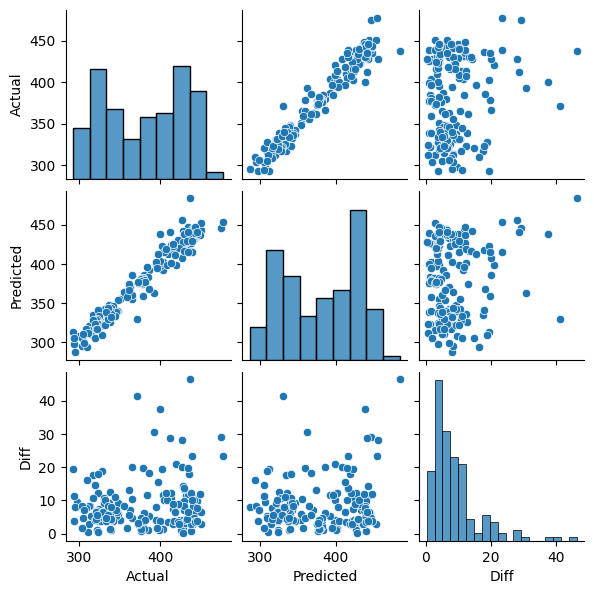

In [14]:
sns.pairplot(Combined, diag_kind='hist', height=2)

In [15]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x=sm.add_constant(X)
result=sm.OLS(y,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     3684.
Date:                Fri, 13 Oct 2023   Prob (F-statistic):          4.56e-193
Time:                        02:12:29   Log-Likelihood:                -1025.0
No. Observations:                 266   AIC:                             2056.
Df Residuals:                     263   BIC:                             2067.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5681      4.831      1.153      0.250      -3.945      15.081
open           0.9809      0.012     80.833      0.000       0.957       1.005
volume      2.236e-07   1.48e-07      1.509      0.133   -6.82e-08    5.15e-07
==============================================================================
Omnibus:                        6.246   Durbin-Watson:                   1.133
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                9.229
Skew:                           0.082   Prob(JB):                      0.00991
Kurtosis:                       3.898   Cond. No.                     6.52e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.52e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
acc=r2_score(Combined["Actual"],Combined["Predicted"])

In [17]:

current_date=datetime.now()
DATE=current_date.strftime("%Y-%m-%d")
CombinedX = pd.concat([Combined, Combined5])
U=CombinedX.loc[:f"{DATE}"]


In [69]:


# Set the figure size
fig = px.scatter(title="Stock Market", width=1000, height=800)

# Plot the actual data as scatter
fig.add_scatter(x=df_target.loc["2023-09-01":f"{DATE}"].index, y=df_target.loc["2023-09-01":f"{DATE}","close"],
                mode='lines+markers', name="Actual", marker=dict(color='blue', size=8))

# Plot the predicted data as line plot
fig.add_scatter(x=CombinedX.loc["2023-09-01":].index, y=CombinedX.loc["2023-09-01":,"Predicted"],
                mode='lines+markers', name="Predicted",marker=dict(size=5),line=dict(color='red', width=2))

# Add legend and axis labels
fig.update_layout(legend=dict(x=1, y=1), xaxis=dict(title="Date"), yaxis=dict(title="Stock Price"))

# Add gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Calculate and add the prediction accuracy annotation
Acc = r2_score(CombinedX["Actual"], CombinedX["Predicted"])
fig.add_annotation(text=f"The prediction Accuracy is {round(Acc*100,2)}%", xref="paper", yref="paper",
                   x=0.65, y=0.86, font=dict(size=12), showarrow=False, align="left")

# Rotate x-axis tick labels
fig.update_xaxes(tickangle=42)

# Show the plot
fig.show()


In [73]:
CombinedX.iloc[-6:,[1]]

,Predicted
2023-10-12,366.951790
2023-10-13,382.677563
2023-10-14,375.136548
2023-10-15,361.502136
2023-10-16,367.949508
2023-10-17,360.334246


HAC :Hierachical Agglomerative Clustering The Distance between Shift and the origanl data 

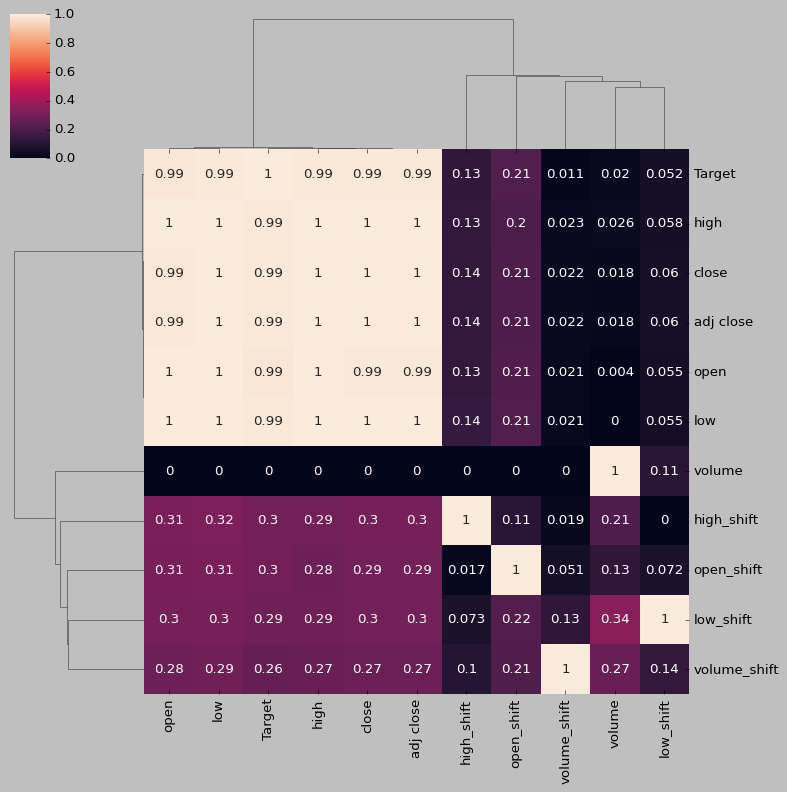

In [25]:
sns.clustermap(df.corr(),annot=True,standard_scale=1)

In [27]:
End=datetime.today().strftime("%H:%M:%S")
End=datetime.strptime(End,"%H:%M:%S")
running_time=f"The running time is {End-Start}"
running_time

'The running time is 0:00:11'